In [1]:
%%capture
%matplotlib inline
import sys
sys.path.insert(1, './PoseCNN-PyTorch/lib')
from datasets.factory import get_dataset
from fcn.config import cfg, cfg_from_file, yaml_from_file, get_output_dir
from fcn.test_imageset import test_image
from ycb_renderer import YCBRenderer
from get_available_devices import *
import torch
import numpy as np
import torch
import torch.nn.parallel 
import torch.backends.cudnn as cudnn 
import networks
from utils.nms import *
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 9]
from utils.blob import pad_im, chromatic_transform, add_noise
from transforms3d.quaternions import mat2quat, quat2mat
from utils.se3 import *
from utils.pose_error import *
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

from ProgressNerf.Dataloading.YCBVideoDataloader import YCBVideoDataloader
# import ProgressNerf.Dataloading.ToolsPartsDataloader

import ProgressNerf.Raycasting.VoxelGridBBoxRaysampler
import ProgressNerf.Raycasting.RandomRaypicker
import ProgressNerf.Raycasting.NearFarRaysampler
import ProgressNerf.Raycasting.WeightedRaypicker
import ProgressNerf.Raycasting.PerturbedRaysampler

import ProgressNerf.NeuralRendering.NeuralRenderer
# import ProgressNerf.NeuralRendering.VoxelNeuralRenderer

import ProgressNerf.Encoders.PositionalEncoder

# import ProgressNerf.Models.OGNerf
# from ProgressNerf.Architectures.OGNerfArch import OGNerfArch
import ProgressNerf.Models.FastNerf
from ProgressNerf.Architectures.VoxelGridCachedNerf import VoxelGridCachedNerf

from ProgressNerf.Utils.CameraUtils import BuildCameraMatrix
from fcn.train import loss_cross_entropy, smooth_l1_loss

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Setup Dataloader & Metadata for PoseCNN

In [3]:
%%capture
cfg_from_file("./PoseCNN-PyTorch/experiments/cfgs/ycb_object.yml")
meta = yaml_from_file("./PoseCNN-PyTorch/data/demo/meta.yml")
dataset = get_dataset("ycb_object_test")
cfg.renderer = YCBRenderer(width=cfg.TRAIN.SYN_WIDTH, height=cfg.TRAIN.SYN_HEIGHT, gpu_id=0, render_marker=False)

worker_init_fn = dataset.worker_init_fn if hasattr(dataset, 'worker_init_fn') else None
num_workers = 0 if cfg.TRAIN.SYNTHESIZE else 4
dataloader = torch.utils.data.DataLoader(dataset, 
                    batch_size=1,  #cfg.TRAIN.IMS_PER_BATCH, 
                    shuffle=True, 
                    num_workers=num_workers, 
                    worker_init_fn=worker_init_fn)

libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL
libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL


number of devices found 5
Loaded EGL 1.5 after reload.


In [4]:
%%capture
if cfg.TEST.SYNTHESIZE:
    cfg.renderer.load_objects(dataset.model_mesh_paths, dataset.model_texture_paths, dataset.model_colors)
else:
    model_mesh_paths = [dataset.model_mesh_paths[i-1] for i in cfg.TEST.CLASSES[1:]]
    model_texture_paths = [dataset.model_texture_paths[i-1] for i in cfg.TEST.CLASSES[1:]]
    model_colors = [dataset.model_colors[i-1] for i in cfg.TEST.CLASSES[1:]]
    cfg.renderer.load_objects(model_mesh_paths, model_texture_paths, model_colors)

cfg.renderer.set_camera_default()
cfg.TEST.POSE_REFINE = False
cfg.TEST.VISUALIZE = False 
cfg.TRAIN.VERTEX_REG = True
cfg.TRAIN.POSE_REG = True

cfg.MODE = 'TEST'

cfg.gpu_id = 0
cfg.device = torch.device('cuda:{:d}'.format(cfg.gpu_id))
cfg.instance_id = 0

# Setup Dataloader for our optimization

In [5]:
config_dict = { "baseDataDir": "/home/stanlew/data/ycb-video/tool-parts_dataset/",\
               "scenes": ["0036","0037","0044","0060","0066","0068","0076","0079","0087","0089"],\
               "datasetType": "train",\
               "samplesLimit": -1,\
               "rel_tools": ["04"]}
progNerfDataloader = torch.utils.data.DataLoader(YCBVideoDataloader(config_dict),\
                                                 batch_size = 1,\
                                                 shuffle=True,\
                                                 num_workers = 1)

# Load PoseCNN Network

In [6]:
%%capture
pretrained = "./PoseCNN-PyTorch/data/checkpoints/ycb_object/vgg16_ycb_object_self_supervision_epoch_8.checkpoint.pth"

cfg.TRAIN.FREEZE_LAYERS = False
num_classes = dataset.num_classes
gpu_id = 1
network_data = torch.load(pretrained, map_location = "cpu")
network = networks.__dict__["posecnn"](num_classes, 64, network_data).to(cfg.device)
network = torch.nn.DataParallel(network, device_ids=[cfg.gpu_id]).to(cfg.device)
cudnn.benchmark = True
network.eval()

# Setup NeRF Model

In [7]:
config_file = "./ycbVideo_Soup.yml"
arch = VoxelGridCachedNerf(config_file)

loading config at ./ycbVideo_Soup.yml
parsing config
initializing optimizer
loading model  & optimizer params from /home/stanlew/Documents/ProgressNerfModels/ycb_video/soup_can_6/epoch_200
resuming training from epoch 201...


# Loop Over Data

In [8]:
def getVisualizedImg(sample_img):
    return (sample_img[0].permute(1,2,0) + 1.0 / 2.0).cpu().numpy()

def run_net(network, dataset, im_color, device):
    im_color.to(device)
    
    K = dataset._intrinsic_matrix
    K[2, 2] = 1
    Kinv = np.linalg.pinv(K)
    meta_data = np.zeros((1, 18), dtype=np.float32)
    meta_data[0, 0:9] = K.flatten()
    meta_data[0, 9:18] = Kinv.flatten()
    meta_data = torch.from_numpy(meta_data).to(device).contiguous()
    
    out_prob, out_label, out_vertex, rois, out_pose, out_quaternion =\
        network(im_color, dataset.input_labels.contiguous(), meta_data, \
            dataset.input_extents.contiguous(), dataset.input_gt_boxes.contiguous(),\
            dataset.input_poses.contiguous(), dataset.input_points.contiguous(),\
            dataset.input_symmetry.contiguous())
    
    return out_prob, out_label, out_vertex, rois, out_pose, out_quaternion

def get_depth_rgb_from_render(render_result, num_cameras, width, height):
    rgb_output = render_result['rgb']\
        .reshape((num_cameras, width, height, 3)).transpose(1,2).contiguous()
    depth_output = render_result['depth']\
        .reshape((num_cameras, width, height, 1)).transpose(1,2).contiguous()
    return rgb_output, depth_output

def sample_on_cylinder(height_mm=100, radius_mm=33):
    samples = []
    theta = 0
    z_inc = 0.5
    z = -height_mm/2
    # sample points in cylinder frame
    while z < height_mm/2:
        while theta < 2 * np.pi:
            x = radius_mm * np.cos(theta)
            y = radius_mm * np.sin(theta)
            point = np.array([x, y, z])
            samples.append(point)
            theta += np.pi/6
        theta = 0
        z+=z_inc
    return samples

def sample_from_voxel_grid(grid):
    positive_values = grid.voxels[(grid.voxels[...,-1:].relu() > 0).squeeze()]
    return positive_values

In [9]:
# select the UVW (*not* s) parameters that correspond to the can's geometry
    # get the xyz locations from the Can sampler
can_samples = torch.from_numpy(np.array(sample_on_cylinder())).to(cfg.device) / 1000.0 # convert to meters

In [10]:
    # grab the voxel cache from the architecture
uvws_cache = arch.uvws_cache
uvws_cache.requires_grad = True

In [11]:

# get the voxel data that correspond to the sampled points
#uvws = uvws_cache.get_voxels_xyz(can_samples)
#sigmas = uvws[...,-1:]
params = [sample_from_voxel_grid(uvws_cache)[...,:-1]] # only add the uvw to the optimization parameters - we dont want to perturb sigma
# create optimizer
optimizer = torch.optim.Adam(params, lr=0.0075)

In [12]:
def NerfRenderSegLoss(inferred_probs, gt_mask):
    return torch.sum(1.0 - (inferred_probs[0,4] * gt_mask[0])) / torch.sum(gt_seg)

In [13]:
def getBack(var_grad_fn):
    print(var_grad_fn)
    for n in var_grad_fn.next_functions:
        if n[0]:
            try:
                tensor = getattr(n[0], 'variable')
                print(n[0])
                print('Tensor with grad found:', tensor)
                print(' - gradient:', tensor.grad)
                print()
            except AttributeError as e:
                getBack(n[0])

torch.Size([1, 128, 2])
0
1


IndexError: index 1 is out of bounds for dimension 0 with size 1

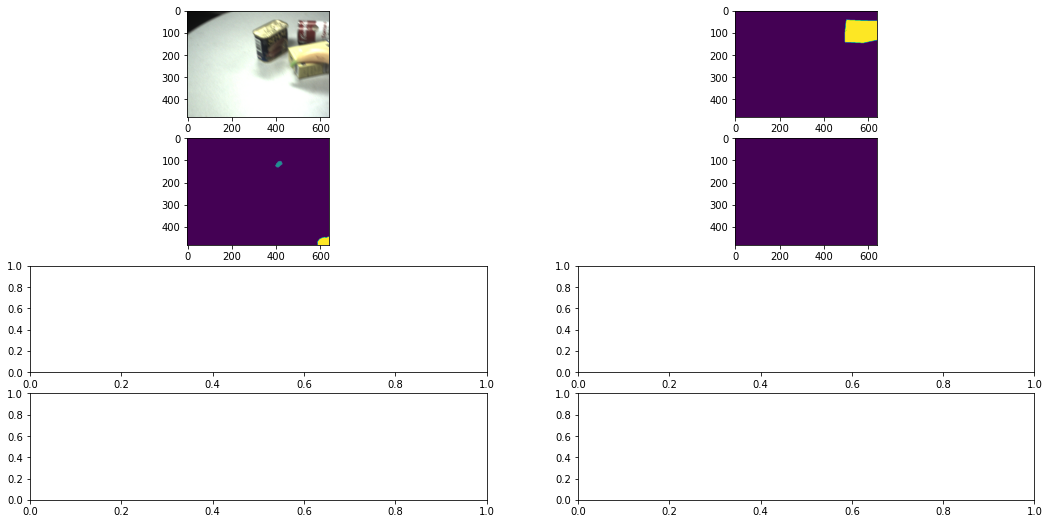

In [22]:
fig, axs = plt.subplots(4,2)  
showFigs = True
for batch_ndx, sample in enumerate(iter(progNerfDataloader)):
    #print(sample.keys())
    gt_seg = sample['segmentation'].to(cfg.device)
    image_color = sample['image'].to(cfg.device).permute((0,3,1,2)).contiguous()
    
    # get the weighting matrix for sampling pixels
    weighting_seg = (gt_seg[0] == 4) * 1.0
    weighting_seg = weighting_seg / torch.sum(weighting_seg)
    cam_pose = torch.eye(4, device=cfg.device).unsqueeze(0)
    ray_origins, ray_dirs, ijs =\
        arch.raypicker.getRays(cam_pose, ray_weights = weighting_seg.repeat(cam_pose.shape[0],1,1))
    
    if showFigs:
        axs[0, 0].imshow(sample['image'][0].cpu().numpy())
        axs[0, 1].imshow(sample['segmentation'][0].cpu().numpy() == 4)
        
    #print(image_color.shape)
    with torch.no_grad():
        pcnn_prob, pcnn_label, pcnn_vertex, pcnn_rois, pcnn_pose, pcnn_quaternion =\
            run_net(network, dataset, image_color, cfg.device)

        #print(pcnn_rois)
        index = torch.where(pcnn_rois[:, -1] > cfg.TEST.DET_THRESHOLD)[0]
        #print(index)
        if showFigs:
            axs[1, 0].imshow(pcnn_label.cpu().numpy()[0])
            axs[1, 1].imshow(pcnn_label.cpu().numpy()[0] == 4)
        for j in range(pcnn_rois.shape[0]):
            pcnn_rois[j, 1] = cfg.TRAIN.CLASSES.index(cfg.TEST.CLASSES[int(pcnn_rois[j,1])])
    
    # render arch at pose from sample
    sample_pose = torch.linalg.inv(sample['04_pose'])
    render_result = arch.render(ray_origins, ray_dirs, use_cache = True)
    
    #render_result = arch.doFullRender(sample_pose, use_cache = True)
    #render_result['rgb'].requires_grad = True
    #render_result['rgb'].retain_grad()
    #nerf_rgb, nerf_depth = get_depth_rgb_from_render(render_result, 1, 640, 480)
    #nerf_rgb.requires_grad = True
    #nerf_rgb.retain_grad()
    # overlay the nerf_rgb into the scene
    overlayed = image_color.permute(0,2,3,1).clone()
    #print(overlayed.shape)
    #overlayed[0, (sample['segmentation'][0].cpu().numpy() == 4), ...] =\
    #    nerf_rgb[0, (sample['segmentation'][0].cpu().numpy() == 4), ...]
    print(ijs.shape)

    for i in range(render_result['rgb_alpha'][0].shape[0]):
        print(i)
        overlayed[0, ijs[i,:,1], ijs[i,:,0], :] = render_result['rgb_alpha'][0,i]
        #gt_pixels[i] = gt_pixels[i] + segmented_gt[0, ijs[i,:,1], ijs[i,:,0], :]
        #gt_depths[i] = gt_depths[i] + seg_depth_gt[0, ijs[i,:,1], ijs[i,:,0]]
    
    if showFigs:
        #axs[2, 0].imshow(nerf_rgb.cpu().detach().numpy()[0])
        axs[2, 1].imshow(overlayed.cpu().detach().numpy()[0])
    
    # run poseCNN on the updated scene
    overlayed = overlayed.permute(0,3,1,2)
    
    overlayed.requires_grad = True
    network.requires_grad = True
    overlayed.retain_grad()
    pcnn_prob, pcnn_label, pcnn_vertex, pcnn_rois, pcnn_pose, pcnn_quaternion =\
        run_net(network, dataset, overlayed, cfg.device)

    if showFigs:
        axs[3, 0].imshow(pcnn_label.cpu().numpy()[0])
        #axs[3, 1].imshow(pcnn_label.cpu().numpy()[0] == 4)
        axs[3, 1].imshow(pcnn_prob[0,4].cpu().detach().numpy())
        
    #print(params[0].grad)
    pcnn_prob.retain_grad()
    loss = NerfRenderSegLoss(pcnn_prob, gt_seg == 4)
    print(loss)
    loss.backward()
    #print(loss.grad)
    #print(params[0])
    print(params[0].grad)
    print(pcnn_prob.grad.shape)
    print(overlayed.grad.unique())
    print(nerf_rgb.grad.unique())
    print(render_result['rgb'].grad.unique())
    #getBack(loss.grad_fn)
    nerf_rgb.grad
    optimizer.step()
    optimizer.zero_grad()
    if showFigs:
        raise Exception("stopping to print")